# Classification Neural Net (self-written layers)

<div id="toc"></div>

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import strip_tags
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from pathlib import Path
import os

## 1. Load Data

In [6]:
data_path = Path(os.getcwd())/'aclImdb'
train_path = data_path/'train'
test_path = data_path/'test'

In [7]:
train_labels_data = []
train_reviews = []

for review in ['pos','neg']:
    for p in (train_path/review).glob('*.txt'):
        with open(p, encoding='utf-8') as f:
            train_reviews.append(f.read())
        if review == 'pos':
            train_labels_data.append(1)
        else: 
            train_labels_data.append(0)

In [8]:
test_labels = []
test_reviews = []

for review in ['pos','neg']:
    for p in (test_path/review).glob('*.txt'):
        with open(p, encoding='utf-8') as f:
            test_reviews.append(f.read())
        if review == 'pos':
            test_labels.append(1)
        else: test_labels.append(0)

In [9]:
# remove tags in the strings
train_reviews = list(map(strip_tags, train_reviews))
test_reviews = list(map(strip_tags, test_reviews))

In [10]:
all_reviews = train_reviews + test_reviews

In [11]:
len(train_reviews), len(test_reviews), len(all_reviews)

(25000, 25000, 50000)

In [12]:
len(train_labels_data), len(test_labels)

(25000, 25000)

## 2. Vectorizer & DTM

In [13]:
# vectorizer = CountVectorizer(max_df=.3, min_df=.01, stop_words='english',
#                              binary='False', ngram_range=(1,2))      # include single tokens & pairs of tokens

In [14]:
vectorizer = TfidfVectorizer(max_df=.3, min_df=.01, stop_words='english',
                             strip_accents='unicode', ngram_range=(1,2))  

In [15]:
all_dtm = vectorizer.fit_transform(all_reviews)

In [16]:
len(vectorizer.vocabulary_)

1640

In [17]:
all_dtm

<50000x1640 sparse matrix of type '<class 'numpy.float64'>'
	with 2568140 stored elements in Compressed Sparse Row format>

## 3. Use 4 topics

### (1) LDA - base model with 'batch' method (4)
- Generate an array of topic distributions as an encoding for both training and test datasets.

In [18]:
n_components = 4

In [20]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1,
                                     n_jobs = -1) # use all processors
lda_base.fit(all_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 1896.0016
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 1890.7128
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 1889.9149
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=4, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [21]:
topics_count = lda_base.components_
topics_count.shape

(4, 1640)

In [22]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)

In [23]:
thetas = lda_base.transform(all_dtm)

In [24]:
all_encoding = thetas @ topics_prob

In [25]:
train_encoding = all_encoding[:25000]
test_encoding = all_encoding[25000:]

In [26]:
train_encoding.shape, test_encoding.shape, all_encoding.shape

((25000, 1640), (25000, 1640), (50000, 1640))

In [34]:
train_encoding[0]

array([0.00232412, 0.00049374, 0.00033289, ..., 0.00053836, 0.0001713 ,
       0.00052257])

### (2) Classification Neural Net (4)
- Write a neural network with several layers with different activation functions 
- Use the encoding from the topic distributions from LDA to train the Classification Neural Network using training data and evaluate the model using test data.
- Note: fit the model using Cross Entropy loss function, and the Adam optimizer

In [47]:
# training data: split into train & valid
train_set, valid_set, train_labels, valid_labels = train_test_split(train_encoding, train_labels_data, 
                                                                    test_size=0.1, shuffle=True)

In [48]:
train_tensors = torch.Tensor(train_set)
valid_tensors = torch.Tensor(valid_set)

train_labels = torch.LongTensor(train_labels)
valid_labels = torch.LongTensor(valid_labels)

In [49]:
train_tensors.shape, valid_tensors.shape

(torch.Size([22500, 1640]), torch.Size([2500, 1640]))

In [50]:
# test data
test_tensors = torch.Tensor(test_encoding)

In [51]:
test_tensors.shape

torch.Size([25000, 1640])

In [99]:
class DropoutMovieReviewClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.fc0 = nn.Linear(self.vocab_size, self.embedding_dim)
        self.fc1 = nn.Linear(self.embedding_dim, 50)
        self.fc2 = nn.Linear(50, 2)
        self.relu = nn.ReLU()      
        self.dropout_0 = nn.Dropout(0.6)
        self.dropout_1 = nn.Dropout(0.5)
        
    def forward(self, inputs):
        out = self.fc0(inputs)
        out = self.dropout_0(out)
        
        out = self.relu(out)
        out = self.fc1(out)
        out = self.dropout_1(out)
        
        out = self.relu(out)
        out = self.fc2(out)
        
        prob = torch.softmax(out, 1)   
        return prob

In [100]:
model = DropoutMovieReviewClassifier(vocab_size=len(vectorizer.vocabulary_), embedding_dim=64)

In [101]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)     # use Adam optimizer

In [102]:
train_set = TensorDataset(train_tensors, train_labels)
valid_set = TensorDataset(valid_tensors, valid_labels)

In [103]:
data_loader = DataLoader(train_set, batch_size=256)

In [104]:
len(data_loader)

88

In [105]:
batch = next(iter(data_loader))
# batch
# batch[0]   # the input features
# batch[1]   # the labels
# model(batch[0])  # the output probs for each label from the NN model
loss_function(model(batch[0]), batch[1])  # the loss computed for this batch

tensor(0.6934, grad_fn=<NllLossBackward>)

In [68]:
losses = []
valid_losses = []

for epoch in range(100):
    running_loss = 0
    for context, target in data_loader:
        
        model.zero_grad()
        
        prob = model(context)
        
        loss = loss_function(prob, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()/100.
    
    valid_pred = model(valid_tensors)
    valid_loss = loss_function(valid_pred,valid_labels).item()
    losses.append(running_loss)
    valid_losses.append(valid_loss)
    print(f'{epoch+1, running_loss, valid_loss}')

(1, 0.6070410072803496, 0.6752611994743347)
(2, 0.5485891723632814, 0.5833370685577393)
(3, 0.4977596926689146, 0.5635492205619812)
(4, 0.48589767456054683, 0.5539677143096924)
(5, 0.48120275557041164, 0.5522963404655457)
(6, 0.4790387558937075, 0.5525303483009338)
(7, 0.47741312652826323, 0.5510824918746948)
(8, 0.475621935725212, 0.5510105490684509)
(9, 0.47477861464023585, 0.5467371344566345)
(10, 0.47558979153633124, 0.5475261211395264)
(11, 0.4760843217372896, 0.5471673607826233)
(12, 0.4751555645465849, 0.5490910410881042)
(13, 0.4744142597913744, 0.5480917096138)
(14, 0.4748287680745125, 0.5490391850471497)
(15, 0.4745420140028002, 0.5496672987937927)
(16, 0.47299739211797714, 0.5504743456840515)
(17, 0.4733844250440596, 0.5469009280204773)
(18, 0.4734008362889289, 0.5483916997909546)
(19, 0.47508610665798184, 0.5476292967796326)
(20, 0.47372845858335505, 0.5453813672065735)
(21, 0.47358956515789014, 0.5489489436149597)
(22, 0.47339731216430675, 0.5467628240585327)
(23, 0.473285

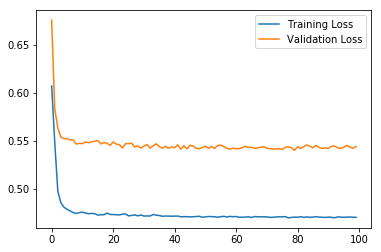

In [69]:
plt.plot(losses, label='Training Loss');
plt.plot(valid_losses, label='Validation Loss');
plt.legend();

In [111]:
# predicted label for test
model.train = False
predictions = model(test_tensors).detach().numpy()
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))

In [112]:
# true label of test
test_labels = np.array(test_labels)  

In [113]:
# prediction accuracy
precision = len(test_labels[test_labels==predictions]) / len(test_labels)
precision

0.49988

## 4. Use 5 topics

### (1) LDA - base model with 'batch' method (5)
- Generate an array of topic distributions as an encoding for both training and test datasets.

In [114]:
n_components = 5

In [115]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1,
                                     n_jobs = -1) # use all processors
lda_base.fit(all_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 2014.9149
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 2013.5109
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 2013.1869
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [116]:
topics_count = lda_base.components_
topics_count.shape

(5, 1640)

In [117]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)

In [118]:
thetas = lda_base.transform(all_dtm)

In [119]:
all_encoding = thetas @ topics_prob

In [120]:
train_encoding = all_encoding[:25000]
test_encoding = all_encoding[25000:]

In [121]:
train_encoding.shape, test_encoding.shape, all_encoding.shape

((25000, 1640), (25000, 1640), (50000, 1640))

In [122]:
train_encoding[0]

array([0.00150791, 0.00020592, 0.00025215, ..., 0.00053598, 0.00016005,
       0.00029668])

### (2) Classification Neural Net (5)
- Write a neural network with several layers with different activation functions 
- Use the encoding from the topic distributions from LDA to train the Classification Neural Network using training data and evaluate the model using test data.
- Note: fit the model using Cross Entropy loss function, and the Adam optimizer

In [126]:
# training data: split into train & valid
train_set, valid_set, train_labels, valid_labels = train_test_split(train_encoding, train_labels_data, 
                                                                    test_size=0.1, shuffle=True)

In [127]:
train_tensors = torch.Tensor(train_set)
valid_tensors = torch.Tensor(valid_set)

train_labels = torch.LongTensor(train_labels)
valid_labels = torch.LongTensor(valid_labels)

In [128]:
train_tensors.shape, valid_tensors.shape

(torch.Size([22500, 1640]), torch.Size([2500, 1640]))

In [129]:
# test data
test_tensors = torch.Tensor(test_encoding)

In [130]:
test_tensors.shape

torch.Size([25000, 1640])

In [131]:
class DropoutMovieReviewClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.fc0 = nn.Linear(self.vocab_size, self.embedding_dim)
        self.fc1 = nn.Linear(self.embedding_dim, 50)
        self.fc2 = nn.Linear(50, 2)
        self.relu = nn.ReLU()      
        self.dropout_0 = nn.Dropout(0.6)
        self.dropout_1 = nn.Dropout(0.5)
        
    def forward(self, inputs):
        out = self.fc0(inputs)
        out = self.dropout_0(out)
        
        out = self.relu(out)
        out = self.fc1(out)
        out = self.dropout_1(out)
        
        out = self.relu(out)
        out = self.fc2(out)
        
        prob = torch.softmax(out, 1)   
        return prob

In [132]:
model = DropoutMovieReviewClassifier(vocab_size=len(vectorizer.vocabulary_), embedding_dim=64)

In [133]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)     # use Adam optimizer

In [134]:
train_set = TensorDataset(train_tensors, train_labels)
valid_set = TensorDataset(valid_tensors, valid_labels)

In [135]:
data_loader = DataLoader(train_set, batch_size=256)

In [136]:
len(data_loader)

88

In [137]:
batch = next(iter(data_loader))
# batch
# batch[0]   # the input features
# batch[1]   # the labels
# model(batch[0])  # the output probs for each label from the NN model
loss_function(model(batch[0]), batch[1])  # the loss computed for this batch

tensor(0.6923, grad_fn=<NllLossBackward>)

In [138]:
losses = []
valid_losses = []

for epoch in range(100):
    running_loss = 0
    for context, target in data_loader:
        
        model.zero_grad()
        
        prob = model(context)
        
        loss = loss_function(prob, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()/100.
    
    valid_pred = model(valid_tensors)
    valid_loss = loss_function(valid_pred,valid_labels).item()
    losses.append(running_loss)
    valid_losses.append(valid_loss)
    print(f'{epoch+1, running_loss, valid_loss}')

(1, 0.6052886319160462, 0.6682671308517456)
(2, 0.5403685456514359, 0.580305814743042)
(3, 0.499920790195465, 0.5677986145019531)
(4, 0.4932781469821931, 0.5650897026062012)
(5, 0.4901494562625884, 0.5634192228317261)
(6, 0.4886767303943633, 0.5641675591468811)
(7, 0.4887469854950904, 0.5616903305053711)
(8, 0.4869280940294265, 0.562683641910553)
(9, 0.4865537577867509, 0.559740424156189)
(10, 0.4865375363826752, 0.5599561929702759)
(11, 0.48604884922504443, 0.5630185604095459)
(12, 0.4859671080112458, 0.5600020289421082)
(13, 0.4846315184235574, 0.5604970455169678)
(14, 0.48543724596500404, 0.5608579516410828)
(15, 0.48536373019218454, 0.5622210502624512)
(16, 0.48492009729146934, 0.5607587695121765)
(17, 0.48536528259515765, 0.5602861046791077)
(18, 0.4852355968952178, 0.5600785613059998)
(19, 0.48454621672630316, 0.5607052445411682)
(20, 0.48467173695564286, 0.5582805871963501)
(21, 0.4845355987548831, 0.5586020946502686)
(22, 0.4842129695415495, 0.5603294968605042)
(23, 0.484238981

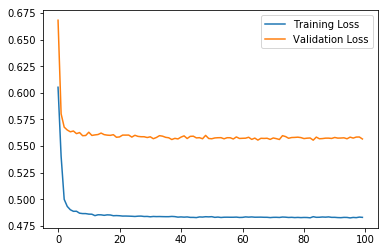

In [139]:
plt.plot(losses, label='Training Loss');
plt.plot(valid_losses, label='Validation Loss');
plt.legend();

In [140]:
# predicted label for test
model.train = False
predictions = model(test_tensors).detach().numpy()
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))

In [141]:
# true label of test
test_labels = np.array(test_labels)  

In [142]:
# prediction accuracy
precision = len(test_labels[test_labels==predictions]) / len(test_labels)
precision

0.75488

## 5. Use 6 topics

### (1) LDA - base model with 'batch' method (6)
- Generate an array of topic distributions as an encoding for both training and test datasets.

In [143]:
n_components = 6

In [144]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1,
                                     n_jobs = -1) # use all processors
lda_base.fit(all_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 2120.6760
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 2113.5614
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 2110.9272
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=6, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [145]:
topics_count = lda_base.components_
topics_count.shape

(6, 1640)

In [146]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)

In [147]:
thetas = lda_base.transform(all_dtm)

In [148]:
all_encoding = thetas @ topics_prob

In [149]:
train_encoding = all_encoding[:25000]
test_encoding = all_encoding[25000:]

In [150]:
train_encoding.shape, test_encoding.shape, all_encoding.shape

((25000, 1640), (25000, 1640), (50000, 1640))

In [151]:
train_encoding[0]

array([3.10246778e-03, 7.16564598e-04, 3.89974772e-04, ...,
       8.43699732e-04, 1.18413292e-04, 8.71837834e-05])

### (2) Classification Neural Net (6)
- Write a neural network with several layers with different activation functions 
- Use the encoding from the topic distributions from LDA to train the Classification Neural Network using training data and evaluate the model using test data.
- Note: fit the model using Cross Entropy loss function, and the Adam optimizer

In [152]:
# training data: split into train & valid
train_set, valid_set, train_labels, valid_labels = train_test_split(train_encoding, train_labels_data, 
                                                                    test_size=0.1, shuffle=True)

In [153]:
train_tensors = torch.Tensor(train_set)
valid_tensors = torch.Tensor(valid_set)

train_labels = torch.LongTensor(train_labels)
valid_labels = torch.LongTensor(valid_labels)

In [154]:
train_tensors.shape, valid_tensors.shape

(torch.Size([22500, 1640]), torch.Size([2500, 1640]))

In [155]:
# test data
test_tensors = torch.Tensor(test_encoding)

In [156]:
test_tensors.shape

torch.Size([25000, 1640])

In [157]:
class DropoutMovieReviewClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.fc0 = nn.Linear(self.vocab_size, self.embedding_dim)
        self.fc1 = nn.Linear(self.embedding_dim, 50)
        self.fc2 = nn.Linear(50, 2)
        self.relu = nn.ReLU()      
        self.dropout_0 = nn.Dropout(0.6)
        self.dropout_1 = nn.Dropout(0.5)
        
    def forward(self, inputs):
        out = self.fc0(inputs)
        out = self.dropout_0(out)
        
        out = self.relu(out)
        out = self.fc1(out)
        out = self.dropout_1(out)
        
        out = self.relu(out)
        out = self.fc2(out)
        
        prob = torch.softmax(out, 1)   
        return prob

In [158]:
model = DropoutMovieReviewClassifier(vocab_size=len(vectorizer.vocabulary_), embedding_dim=64)

In [159]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)     # use Adam optimizer

In [160]:
train_set = TensorDataset(train_tensors, train_labels)
valid_set = TensorDataset(valid_tensors, valid_labels)

In [161]:
data_loader = DataLoader(train_set, batch_size=256)

In [162]:
len(data_loader)

88

In [163]:
batch = next(iter(data_loader))
# batch
# batch[0]   # the input features
# batch[1]   # the labels
# model(batch[0])  # the output probs for each label from the NN model
loss_function(model(batch[0]), batch[1])  # the loss computed for this batch

tensor(0.6964, grad_fn=<NllLossBackward>)

In [164]:
losses = []
valid_losses = []

for epoch in range(100):
    running_loss = 0
    for context, target in data_loader:
        
        model.zero_grad()
        
        prob = model(context)
        
        loss = loss_function(prob, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()/100.
    
    valid_pred = model(valid_tensors)
    valid_loss = loss_function(valid_pred,valid_labels).item()
    losses.append(running_loss)
    valid_losses.append(valid_loss)
    print(f'{epoch+1, running_loss, valid_loss}')

(1, 0.60701467692852, 0.6779059171676636)
(2, 0.5560256999731064, 0.5887598395347595)
(3, 0.5092229366302489, 0.5721312761306763)
(4, 0.5010752308368683, 0.5693526864051819)
(5, 0.49641657471656797, 0.5676136016845703)
(6, 0.4949499422311782, 0.5663478970527649)
(7, 0.494926727414131, 0.5650187730789185)
(8, 0.4942194926738739, 0.5601612329483032)
(9, 0.4929244810342789, 0.5645074248313904)
(10, 0.4919199359416959, 0.5633651614189148)
(11, 0.49167075812816624, 0.5623024702072144)
(12, 0.4916593575477599, 0.5631875991821289)
(13, 0.49107300341129295, 0.5612450242042542)
(14, 0.49030068010091793, 0.5613555312156677)
(15, 0.49110421776771535, 0.5619827508926392)
(16, 0.4904589694738388, 0.5600152611732483)
(17, 0.4886917388439177, 0.5592461228370667)
(18, 0.48998909831047044, 0.5634702444076538)
(19, 0.4893537491559983, 0.5622383952140808)
(20, 0.4898127657175063, 0.5612767934799194)
(21, 0.4892180293798448, 0.5616015791893005)
(22, 0.488867427110672, 0.5601691603660583)
(23, 0.4889353686

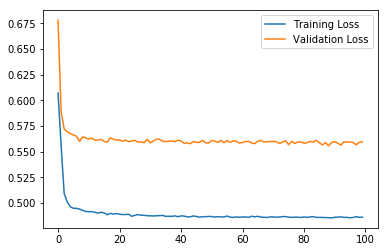

In [165]:
plt.plot(losses, label='Training Loss');
plt.plot(valid_losses, label='Validation Loss');
plt.legend();

In [166]:
# predicted label for test
model.train = False
predictions = model(test_tensors).detach().numpy()
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))

In [167]:
# true label of test
test_labels = np.array(test_labels)  

In [168]:
# prediction accuracy
precision = len(test_labels[test_labels==predictions]) / len(test_labels)
precision

0.75912

## 6. Use 7 topics

### (1) LDA - base model with 'batch' method (7)
- Generate an array of topic distributions as an encoding for both training and test datasets.

In [18]:
n_components = 7

In [19]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1,
                                     n_jobs = -1) # use all processors
lda_base.fit(all_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 2208.5825
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 2204.9613
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 2201.3653
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=7, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [20]:
topics_count = lda_base.components_
topics_count.shape

(7, 1640)

In [21]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)

In [22]:
thetas = lda_base.transform(all_dtm)

In [23]:
all_encoding = thetas @ topics_prob

In [24]:
train_encoding = all_encoding[:25000]
test_encoding = all_encoding[25000:]

In [25]:
train_encoding.shape, test_encoding.shape, all_encoding.shape

((25000, 1640), (25000, 1640), (50000, 1640))

In [26]:
train_encoding[0]

array([0.00153925, 0.00019557, 0.00030198, ..., 0.00068887, 0.00020248,
       0.00017442])

### (2) Classification Neural Net (7)
- Write a neural network with several layers with different activation functions 
- Use the encoding from the topic distributions from LDA to train the Classification Neural Network using training data and evaluate the model using test data.
- Note: fit the model using Cross Entropy loss function, and the Adam optimizer

In [27]:
# training data: split into train & valid
train_set, valid_set, train_labels, valid_labels = train_test_split(train_encoding, train_labels_data, 
                                                                    test_size=0.1, shuffle=True)

In [28]:
train_tensors = torch.Tensor(train_set)
valid_tensors = torch.Tensor(valid_set)

train_labels = torch.LongTensor(train_labels)
valid_labels = torch.LongTensor(valid_labels)

In [29]:
train_tensors.shape, valid_tensors.shape

(torch.Size([22500, 1640]), torch.Size([2500, 1640]))

In [30]:
# test data
test_tensors = torch.Tensor(test_encoding)

In [31]:
test_tensors.shape

torch.Size([25000, 1640])

In [32]:
class DropoutMovieReviewClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.fc0 = nn.Linear(self.vocab_size, self.embedding_dim)
        self.fc1 = nn.Linear(self.embedding_dim, 50)
        self.fc2 = nn.Linear(50, 2)
        self.relu = nn.ReLU()      
        self.dropout_0 = nn.Dropout(0.6)
        self.dropout_1 = nn.Dropout(0.5)
        
    def forward(self, inputs):
        out = self.fc0(inputs)
        out = self.dropout_0(out)
        
        out = self.relu(out)
        out = self.fc1(out)
        out = self.dropout_1(out)
        
        out = self.relu(out)
        out = self.fc2(out)
        
        prob = torch.softmax(out, 1)   
        return prob

In [33]:
model = DropoutMovieReviewClassifier(vocab_size=len(vectorizer.vocabulary_), embedding_dim=64)

In [34]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)     # use Adam optimizer

In [35]:
train_set = TensorDataset(train_tensors, train_labels)
valid_set = TensorDataset(valid_tensors, valid_labels)

In [36]:
data_loader = DataLoader(train_set, batch_size=256)

In [37]:
len(data_loader)

88

In [38]:
batch = next(iter(data_loader))
# batch
# batch[0]   # the input features
# batch[1]   # the labels
# model(batch[0])  # the output probs for each label from the NN model
loss_function(model(batch[0]), batch[1])  # the loss computed for this batch

tensor(0.6932, grad_fn=<NllLossBackward>)

In [39]:
losses = []
valid_losses = []

for epoch in range(100):
    running_loss = 0
    for context, target in data_loader:
        
        model.zero_grad()
        
        prob = model(context)
        
        loss = loss_function(prob, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()/100.
    
    valid_pred = model(valid_tensors)
    valid_loss = loss_function(valid_pred,valid_labels).item()
    losses.append(running_loss)
    valid_losses.append(valid_loss)
    print(f'{epoch+1, running_loss, valid_loss}')

(1, 0.6069779342412954, 0.6765757203102112)
(2, 0.5531528377532958, 0.583331286907196)
(3, 0.5094244378805161, 0.5684912800788879)
(4, 0.5026240974664689, 0.564281702041626)
(5, 0.4996073091030122, 0.559272289276123)
(6, 0.49728246390819525, 0.5600306987762451)
(7, 0.497074385881424, 0.5625910758972168)
(8, 0.49654533684253704, 0.5583384037017822)
(9, 0.49513080596923836, 0.5570482611656189)
(10, 0.49471333026886005, 0.5558308362960815)
(11, 0.49388461410999307, 0.5565588474273682)
(12, 0.4943635147809982, 0.5569625496864319)
(13, 0.49284231424331665, 0.5586915612220764)
(14, 0.49363419234752665, 0.5569464564323425)
(15, 0.4926480305194855, 0.5572473406791687)
(16, 0.4916831266880036, 0.5589306354522705)
(17, 0.4920183277130126, 0.5563476085662842)
(18, 0.4917566269636154, 0.5558330416679382)
(19, 0.4920965605974199, 0.5559006929397583)
(20, 0.4915189427137375, 0.5547791719436646)
(21, 0.49206019222736347, 0.555969774723053)
(22, 0.49147094964981075, 0.5548352003097534)
(23, 0.49109766

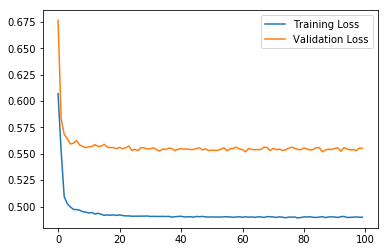

In [40]:
plt.plot(losses, label='Training Loss');
plt.plot(valid_losses, label='Validation Loss');
plt.legend();

In [41]:
# predicted label for test
model.train = False
predictions = model(test_tensors).detach().numpy()
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))

In [42]:
# true label of test
test_labels = np.array(test_labels)  

In [43]:
# prediction accuracy
precision = len(test_labels[test_labels==predictions]) / len(test_labels)
precision

0.7468

## 7. Results

Using my own Classification Neural Network, the precision for each topic is shown as below:

- (1) **4 topics**: precision = 0.49988
- (2) **5 topics**: precision = 0.75488
- (3) **6 topics**: precision = 0.75912
- (4) **7 topics**: precision = 0.7468

As a result, the 6-topic LDA model provides the highest precision, thus it is the best model to encode movie reviews in this question for my own written Classification Neural Network.